# Process

1.) Find BPM ranges for each popular musical genre

2.) List top 50 Pop tracks per year from 2013 to 2018

3.) Get BPM rate for all tracks

4.) Associate musical genres for each track

5.) Analyse data for: charts, years, BPM, genres and duration

In [1]:
from bs4 import BeautifulSoup
from getpass import getpass
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import re
import requests
from requests.auth import HTTPBasicAuth
import seaborn as sb

## Genre Beats Per Minute Dataframe: genre_bpm

Data scrapping https://www.musical-u.com/
to get the BPM values per genre

In [2]:
url = 'https://www.musical-u.com/learn/rhythm-tips-for-identifying-music-genres-by-ear/'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
html = requests.get(url, headers=headers).content
soup = BeautifulSoup(html, features="lxml")

a = soup.find_all('table', attrs = {'class':'table table-bordered'})[0]
a1 = a.get_text(',', strip='<td>''</td>')
bpm_list1 = a1.split(",")

del bpm_list1[0]
del bpm_list1[0]

def listToDict(lst):
    op = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return op

bpm_dict = listToDict(bpm_list1)

bpm_df1 = pd.DataFrame.from_dict(bpm_dict, orient='index').reset_index()
bpm_df1

,index,0
0,Reggae,60-90
1,Down-tempo,70-100
2,Chill-out,90-120
3,Hip-hop,85-115
4,Jazz and Funk,120-125
5,Pop,100-130
6,R&B,60-80
7,Rock,110-140
8,Metal,100-160


In [3]:
bpm_df2 = bpm_df1.rename(columns={0: "Range", 'index': 'Genre'})
bpm_df3 = pd.DataFrame(bpm_df2.Range.str.split('-',1).tolist(), columns = ['Min_BPM','Max_BPM'])
bpm_df4 = bpm_df2.merge(bpm_df3,right_index=True,left_index=True)
genre_bpm = bpm_df4.drop(['Range'], axis=1)
genre_bpm.dtypes

Genre      object
Min_BPM    object
Max_BPM    object
dtype: object

In [4]:
genre_bpm['Min_BPM'] = pd.to_numeric(genre_bpm['Min_BPM'])
genre_bpm['Max_BPM'] = pd.to_numeric(genre_bpm['Max_BPM'])
genre_bpm['Avg_BPM'] = genre_bpm[['Min_BPM', 'Max_BPM']].mean(axis=1)
genre_bpm_sort = genre_bpm.sort_values(by ='Avg_BPM' )
genre_bpm_sort

,Genre,Min_BPM,Max_BPM,Avg_BPM
6,R&B,60,80,70.0
0,Reggae,60,90,75.0
1,Down-tempo,70,100,85.0
3,Hip-hop,85,115,100.0
2,Chill-out,90,120,105.0
5,Pop,100,130,115.0
4,Jazz and Funk,120,125,122.5
7,Rock,110,140,125.0
8,Metal,100,160,130.0


In [5]:
#get list of Genres sorted by average BPM to use in yearly correlations
avg_bpm_asc = list(genre_bpm_sort['Genre'])
avg_bpm_asc

['R&B',
 'Reggae',
 'Down-tempo',
 'Hip-hop',
 'Chill-out',
 'Pop',
 'Jazz and Funk',
 'Rock',
 'Metal']

## Deezer Api Scavenger
GET
https://api.deezer.com/version/service/id/method/?parameters

The number of requests per second is limited to 50 requests / 5 seconds: get sample down to 50 songs

All requests and responses must be in UTF-8.

#### 2018: t50_pop_2018

In [6]:
#get 2018's top 50 pop tracks

top_60_pop_2018 = "https://api.deezer.com/playlist/5132762464"

response = requests.get(top_60_pop_2018)

t60_pop_2018a = pd.DataFrame(response.json())
t60_2018b = pd.DataFrame(dict(t60_pop_2018a['tracks']))
t60_2018c = t60_2018b['data'].apply(pd.Series)
t60_2018d = t60_2018c.drop(['title_short', 'title_version', 'readable', 'time_add','link', 'rank' , 'explicit_lyrics', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'artist','album', 'type'], axis=1)
t50_pop_2018 = t60_2018d.rename(columns={"id": "track_id"})[:50]  

In [7]:
#get bpm to 2018 list

tracks_2018 = list(t50_pop_2018['track_id'])

track_data_2018 = []

for item in tracks_2018:
    urls = "https://api.deezer.com/track/"+ str(item)
    r = requests.get(urls).content.decode('UTF-8')
    a = json.loads(r)     #solution to issue where decoding transforms to a string
    track_data_2018.append(a)
    
df_track_data_2018 = pd.DataFrame(track_data_2018)

tracksbpm_2018 = df_track_data_2018.drop(['readable','title_short', 'title','title_version', 'isrc','link', 'share', 'duration', 'track_position', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'gain', 'available_countries', 'contributors', 'artist', 'album', 'type', 'disk_number', 'rank', 'release_date', 'explicit_lyrics'], axis=1)

#adding bpm to tracks 580705262 & 457305372: https://tunebat.com/

tracksbpm_2018.loc[(tracksbpm_2018['id']==580705262) & (tracksbpm_2018['bpm']==0.000)] = [[580705262,150]]
tracksbpm_2018.loc[(tracksbpm_2018['id']==457305372) & (tracksbpm_2018['bpm']==0.000)] = [[457305372,113]]

t50_pop_2018['bpm'] = tracksbpm_2018['bpm']
t50_pop_2018['chart_position'] = list(range(1,51))
t50_pop_2018['year'] = 2018
t50_pop_2018.head(2)

,track_id,title,duration,bpm,chart_position,year
0,579496662,"thank u, next",207,107.110,1,2018
1,482990352,One Kiss,214,124.155,2,2018


#### 2017: t50_pop_2017

In [8]:
#get 2017's top 50 pop tracks

top_60_pop_2017 = "https://api.deezer.com/playlist/3453772742"

response = requests.get(top_60_pop_2017)

t60_pop_2017a = pd.DataFrame(response.json())
t60_pop_2017b = pd.DataFrame(dict(t60_pop_2017a['tracks']))
t60_pop_2017c = t60_pop_2017b['data'].apply(pd.Series)
t60_pop_2017d = t60_pop_2017c.drop(['title_short', 'title_version', 'readable', 'time_add','link', 'rank' , 'explicit_lyrics', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'artist','album', 'type'], axis=1)
t50_pop_2017 = t60_pop_2017d.rename(columns={"id": "track_id"})[:50] 

In [9]:
#get bpm to 2017 list

tracks_2017 = list(t50_pop_2017['track_id'])

track_data_2017 = []
for item in tracks_2017:
    urls = "https://api.deezer.com/track/"+ str(item)
    r = requests.get(urls).content.decode('UTF-8')
    a = json.loads(r) 
    track_data_2017.append(a)

df_track_data_2017 = pd.DataFrame(track_data_2017)

tracksbpm_2017 = df_track_data_2017.drop(['readable','title_short', 'title','title_version', 'isrc','link', 'share', 'duration', 'track_position', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'gain', 'available_countries', 'contributors', 'artist', 'album', 'type', 'disk_number', 'rank', 'release_date', 'explicit_lyrics'], axis=1)

#adding bpm to tracks 140889759, 351595631 & 140856305: https://tunebat.com/

tracksbpm_2017.loc[(tracksbpm_2017['id']==140889759) & (tracksbpm_2017['bpm']==0.000)] = [[140889759,171]]
tracksbpm_2017.loc[(tracksbpm_2017['id']==351595631) & (tracksbpm_2017['bpm']==0.000)] = [[351595631,122]]
tracksbpm_2017.loc[(tracksbpm_2017['id']==140856305) & (tracksbpm_2017['bpm']==0.000)] = [[140856305,138]]

t50_pop_2017['bpm'] = tracksbpm_2017['bpm']
t50_pop_2017['chart_position'] = list(range(1,51))
t50_pop_2017['year'] = 2017
t50_pop_2017.head(2)

,track_id,title,duration,bpm,chart_position,year
0,142986204,Shape of You,233,95.93,1,2017
1,350428781,Despacito (Remix),228,178.21,2,2017


#### 2016: t50_pop_2016

In [10]:
#get 2016's top 50 pop tracks

top_60_pop_2016 = "https://api.deezer.com/playlist/5310088722"

response = requests.get(top_60_pop_2016)

t60_pop_2016a = pd.DataFrame(response.json())
t60_pop_2016b = pd.DataFrame(dict(t60_pop_2016a['tracks']))
t60_pop_2016c = t60_pop_2016b['data'].apply(pd.Series)
t60_pop_2016d = t60_pop_2016c.drop(['title_short', 'title_version', 'readable', 'time_add','link', 'rank' , 'explicit_lyrics', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'artist','album', 'type'], axis=1)
t50_pop_2016 = t60_pop_2016d.rename(columns={"id": "track_id"})[:50]

In [11]:
#get bpm to 2016 list

tracks_2016 = list(t50_pop_2016['track_id'])

track_data_2016 = []
for item in tracks_2016:
    urls = "https://api.deezer.com/track/"+ str(item)
    r = requests.get(urls).content.decode('UTF-8')
    a = json.loads(r) 
    track_data_2016.append(a)

df_track_data_2016 = pd.DataFrame(track_data_2016)

tracksbpm_2016 = df_track_data_2016.drop(['readable','title_short', 'title','title_version', 'isrc','link', 'share', 'duration', 'track_position', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'gain', 'available_countries', 'contributors', 'artist', 'album', 'type', 'disk_number', 'rank', 'release_date', 'explicit_lyrics'], axis=1)

#adding bpm to tracks 129310248, 129313094, 136889400, 140869461, 136889434: https://tunebat.com/

tracksbpm_2016.loc[(tracksbpm_2016['id']==129310248) & (tracksbpm_2016['bpm']==0.000)] = [[129310248,95]]
tracksbpm_2016.loc[(tracksbpm_2016['id']==129313094) & (tracksbpm_2016['bpm']==0.000)] = [[129313094,134]]
tracksbpm_2016.loc[(tracksbpm_2016['id']==136889400) & (tracksbpm_2016['bpm']==0.000)] = [[136889400,93]]
tracksbpm_2016.loc[(tracksbpm_2016['id']==140869461) & (tracksbpm_2016['bpm']==0.000)] = [[140869461,75]]
tracksbpm_2016.loc[(tracksbpm_2016['id']==136889434) & (tracksbpm_2016['bpm']==0.000)] = [[136889434,93]]

t50_pop_2016['bpm'] = tracksbpm_2016['bpm']
t50_pop_2016['chart_position'] = list(range(1,51))
t50_pop_2016['year'] = 2016
t50_pop_2016.head(2)

,track_id,title,duration,bpm,chart_position,year
0,124603270,One Dance,173,103.88,1,2016
1,134533238,Cheap Thrills,224,179.76,2,2016


#### 2015: t50_pop_2015

In [12]:
#get 2015's top 50 pop tracks

top_60_pop_2015 = "https://api.deezer.com/playlist/5310238702"

response = requests.get(top_60_pop_2015)

t60_pop_2015a = pd.DataFrame(response.json())
t60_pop_2015b = pd.DataFrame(dict(t60_pop_2015a['tracks']))
t60_pop_2015c = t60_pop_2015b['data'].apply(pd.Series)
t60_pop_2015d = t60_pop_2015c.drop(['title_short', 'title_version', 'readable', 'time_add','link', 'rank' , 'explicit_lyrics', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'artist','album', 'type'], axis=1)
t50_pop_2015 = t60_pop_2015d.rename(columns={"id": "track_id"})[:50]

In [13]:
#get bpm to 2015 list

tracks_2015 = list(t50_pop_2015['track_id'])

track_data_2015 = []
for item in tracks_2015:
    urls = "https://api.deezer.com/track/"+ str(item)
    r = requests.get(urls).content.decode('UTF-8')
    a = json.loads(r) 
    track_data_2015.append(a)

df_track_data_2015 = pd.DataFrame(track_data_2015)

tracksbpm_2015 = df_track_data_2015.drop(['readable','title_short', 'title','title_version', 'isrc','link', 'share', 'duration', 'track_position', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'gain', 'available_countries', 'contributors', 'artist', 'album', 'type', 'disk_number', 'rank', 'release_date', 'explicit_lyrics'], axis=1)

#adding bpm to tracks 94664184, 98087618, 124603286, 94195822: https://tunebat.com/

tracksbpm_2015.loc[(tracksbpm_2015['id']==94664184) & (tracksbpm_2015['bpm']==0.000)] = [[94664184,95]]
tracksbpm_2015.loc[(tracksbpm_2015['id']==98087618) & (tracksbpm_2015['bpm']==0.000)] = [[98087618,103]]
tracksbpm_2015.loc[(tracksbpm_2015['id']==124603286) & (tracksbpm_2015['bpm']==0.000)] = [[124603286,135]]
tracksbpm_2015.loc[(tracksbpm_2015['id']==94195822) & (tracksbpm_2015['bpm']==0.000)] = [[94195822,105]]

t50_pop_2015['bpm'] = tracksbpm_2015['bpm']
t50_pop_2015['chart_position'] = list(range(1,51))
t50_pop_2015['year'] = 2015
t50_pop_2015.head(2)

,track_id,title,duration,bpm,chart_position,year
0,112662366,Sorry,200,99.86,1,2015
1,138545995,Hello,295,157.00,2,2015


#### 2014: t50_pop_2014

In [14]:
#get 2014's top 50 pop tracks

top_60_pop_2014 = "https://api.deezer.com/playlist/5310662982"

response = requests.get(top_60_pop_2014)

t60_pop_2014a = pd.DataFrame(response.json())
t60_pop_2014b = pd.DataFrame(dict(t60_pop_2014a['tracks']))
t60_pop_2014c = t60_pop_2014b['data'].apply(pd.Series)
t60_pop_2014d = t60_pop_2014c.drop(['title_short', 'title_version', 'readable', 'time_add','link', 'rank' , 'explicit_lyrics', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'artist','album', 'type'], axis=1)
t50_pop_2014 = t60_pop_2014d.rename(columns={"id": "track_id"})[:50] 

In [15]:
#get bpm to 2014 list

tracks_2014 = list(t50_pop_2014['track_id'])

track_data_2014 = []
for item in tracks_2014:
    urls = "https://api.deezer.com/track/"+ str(item)
    r = requests.get(urls).content.decode('UTF-8')
    a = json.loads(r) 
    track_data_2014.append(a)

df_track_data_2014 = pd.DataFrame(track_data_2014)

tracksbpm_2014 = df_track_data_2014.drop(['readable','title_short', 'title','title_version', 'isrc','link', 'share', 'duration', 'track_position', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'artist', 'gain', 'available_countries', 'contributors', 'album', 'type', 'disk_number', 'rank', 'release_date', 'explicit_lyrics'], axis=1)

#adding bpm to tracks 91543346, 114477752: https://tunebat.com/

tracksbpm_2014.loc[(tracksbpm_2014['id']==91543346) & (tracksbpm_2014['bpm']==0.000)] = [[91543346,130]]
tracksbpm_2014.loc[(tracksbpm_2014['id']==114477752) & (tracksbpm_2014['bpm']==0.000)] = [[114477752,98]]

t50_pop_2014['bpm'] = tracksbpm_2014['bpm']
t50_pop_2014['chart_position'] = list(range(1,51))
t50_pop_2014['year'] = 2014
t50_pop_2014.head(2)

,track_id,title,duration,bpm,chart_position,year
0,89077555,Shake It Off,219,160.25,1,2014
1,79875064,Thinking out Loud,281,157.80,2,2014


#### 2013: t50_pop_2013

In [16]:
#get 2013's top 50 pop tracks

top_60_pop_2013 = "https://api.deezer.com/playlist/5310925582"

response = requests.get(top_60_pop_2013)

t60_pop_2013a = pd.DataFrame(response.json())
t60_pop_2013b = pd.DataFrame(dict(t60_pop_2013a['tracks']))
t60_pop_2013c = t60_pop_2013b['data'].apply(pd.Series)
t60_pop_2013d = t60_pop_2013c.drop(['title_short', 'title_version', 'readable', 'time_add','link', 'rank' , 'explicit_lyrics', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'artist','album', 'type'], axis=1)
t50_pop_2013 = t60_pop_2013d.rename(columns={"id": "track_id"})[:50]

In [17]:
#get bpm to 2013 list

tracks_2013 = list(t50_pop_2013['track_id'])

track_data_2013 = []
for item in tracks_2013:
    urls = "https://api.deezer.com/track/"+ str(item)
    r = requests.get(urls).content.decode('UTF-8')
    a = json.loads(r)
    track_data_2013.append(a)

df_track_data_2013 = pd.DataFrame(track_data_2013)

tracksbpm_2013 = df_track_data_2013.drop(['readable','title_short', 'title','title_version', 'isrc','link', 'share', 'duration', 'track_position', 'explicit_content_lyrics', 'explicit_content_cover', 'preview', 'gain', 'available_countries', 'contributors', 'artist', 'album', 'type', 'disk_number', 'rank', 'release_date', 'explicit_lyrics'], axis=1)

#adding bpm to tracks 70697359, 70697364: https://tunebat.com/
tracksbpm_2013.loc[(tracksbpm_2013['id']==70697359) & (tracksbpm_2013['bpm']==0.000)] = [[70697359,86]]
tracksbpm_2013.loc[(tracksbpm_2013['id']==70697364) & (tracksbpm_2013['bpm']==0.000)] = [[70697364,100]]

t50_pop_2013['bpm'] = tracksbpm_2013['bpm']
t50_pop_2013['chart_position'] = list(range(1,51))
t50_pop_2013['year'] = 2013
t50_pop_2013.head(2)

,track_id,title,duration,bpm,chart_position,year
0,66609426,Get Lucky (Radio Edit),248,116.13,1,2013
1,70266756,Wake Me Up,247,124.20,2,2013


### Aggregating All Data: associate track with genres

In [20]:
all_years_bpm = pd.concat([t50_pop_2013,t50_pop_2014,t50_pop_2015,t50_pop_2016,t50_pop_2017,t50_pop_2018], sort=False)
bpm_list = list(all_years_bpm['bpm'])

In [21]:
genres_per_track_list = []
for x in bpm_list:
    
        if 60 <= x < 70:
            genres_per_track_list.append('R&B'+', '+'Reggae')
        elif 70 <= x < 80:
            genres_per_track_list.append('R&B'+', '+'Reggae'+', '+'Down-tempo')
        elif 80 <= x < 85:
            genres_per_track_list.append('Reggae'+', '+'Down-tempo')
        elif 85 <= x < 90:
            genres_per_track_list.append('Reggae'+', '+'Down-tempo'+', '+'Hip-hop')
        elif 90 <= x < 100:
            genres_per_track_list.append('Down-tempo'+', '+'Hip-hop'+', '+'Chill-out')
        elif x == 100:
            genres_per_track_list.append('Down-tempo'+', '+'Hip-hop'+', '+'Chill-out'+', '+'Pop'+', '+'Metal')
        elif 100 < x < 110:
            genres_per_track_list.append('Hip-hop'+', '+'Chill-out'+', '+'Pop'+', '+'Metal')
        elif 110 <= x < 115:
            genres_per_track_list.append('Hip-hop'+', '+'Chill-out'+', '+'Pop'+', '+'Metal'+', '+'Rock')
        elif 115 <= x < 120:
            genres_per_track_list.append('Chill-out'+', '+'Pop'+', '+'Metal'+', '+'Rock')
        elif x == 120:
            genres_per_track_list.append('Chill-out'+', '+'Pop'+', '+'Metal'+', '+'Rock'+', '+'Jazz and Funk')
        elif 120 < x <= 125:
            genres_per_track_list.append('Pop'+', '+'Metal'+', '+'Rock'+', '+'Jazz and Funk')
        elif 125 < x <= 130:
            genres_per_track_list.append('Pop'+', '+'Metal'+', '+'Rock')
        elif 130 < x <= 140:
            genres_per_track_list.append('Metal'+', '+'Rock')
        elif 140 < x <= 160:
            genres_per_track_list.append('Metal')
        elif x > 160:
            genres_per_track_list.append('Over-160bpm')
        else:
            genres_per_track_list.append('Under-60bpm')

all_years_bpm['genres']= genres_per_track_list

In [22]:
genre_count = dict(all_years_bpm['genres'].str.split(',\s+', expand=True).stack().value_counts())
genre_count

{'Metal': 204,
 'Pop': 147,
 'Chill-out': 142,
 'Rock': 123,
 'Hip-hop': 114,
 'Down-tempo': 60,
 'Over-160bpm': 37,
 'Jazz and Funk': 30,
 'Reggae': 11,
 'R&B': 1}

### Aggregating All Data: distribution of genres per year

In [23]:
#genre aggregation per year

genres_2013 = all_years_bpm[all_years_bpm.year.eq(2013)]
genres_2013_count = dict(genres_2013['genres'].str.split(',\s+', expand=True).stack().value_counts())

genres_2014 = all_years_bpm[all_years_bpm.year.eq(2014)]
genres_2014_count = dict(genres_2014['genres'].str.split(',\s+', expand=True).stack().value_counts())

genres_2015 = all_years_bpm[all_years_bpm.year.eq(2015)]
genres_2015_count = dict(genres_2015['genres'].str.split(',\s+', expand=True).stack().value_counts())

genres_2016 = all_years_bpm[all_years_bpm.year.eq(2016)]
genres_2016_count = dict(genres_2016['genres'].str.split(',\s+', expand=True).stack().value_counts())

genres_2017 = all_years_bpm[all_years_bpm.year.eq(2017)]
genres_2017_count = dict(genres_2017['genres'].str.split(',\s+', expand=True).stack().value_counts())

genres_2018 = all_years_bpm[all_years_bpm.year.eq(2018)]
genres_2018_count = dict(genres_2018['genres'].str.split(',\s+', expand=True).stack().value_counts())

In [24]:
#adding new bpm genre for values over 160, not in web-scrapped table

avg_bpm_asc.append('Over-160bpm')

In [25]:
#cleaning the table

genre_5years_a = pd.DataFrame.from_dict([genres_2013_count, genres_2014_count, genres_2015_count, genres_2016_count, genres_2017_count, genres_2018_count]).fillna(0).astype(int)
genre_5years_a['Years'] = [2013,2014,2015,2016,2017,2018]
genre_5years_b = genre_5years_a.set_index('Years')

genre_5years = genre_5years_b.reindex(columns=avg_bpm_asc)
genre_5years

,R&B,Reggae,Down-tempo,Hip-hop,Chill-out,Pop,Jazz and Funk,Rock,Metal,Over-160bpm
Years,,,,,,,,,,
2013,0,4,8,9,18,28,5,29,38,5
2014,0,2,6,9,15,26,6,26,36,8
2015,0,0,9,22,27,25,5,22,37,4
2016,1,2,9,19,24,24,5,18,31,10
2017,0,3,15,31,31,24,5,13,31,4
2018,0,0,13,24,27,20,4,15,31,6


In [26]:
#Relate chart position section to BPM/Duration regardless of year

data = [all_years_bpm['chart_position'], all_years_bpm['bpm'],all_years_bpm['duration']]
headers = ['chart_position','bpm','duration']

chart_groups = [0,5,10,15,20,25,30,35,40,45,50]
chart_df = pd.concat(data, axis=1, keys=headers)
chart_df['chart_frame'] = pd.cut(chart_df['chart_position'], bins=chart_groups)
chart_df.head(2)

,chart_position,bpm,duration,chart_frame
0,1,116.13,248,"(0, 5]"
1,2,124.20,247,"(0, 5]"


In [27]:
#Get number of tracks per bpm interval

data2 = [all_years_bpm['track_id'], all_years_bpm['bpm']]
headers = ['track_id','bpm']

bpm_groups = [60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200]
bpm_df = pd.concat(data2, axis=1, keys=headers)
bpm_df['bpm_frame'] = pd.cut(bpm_df['bpm'], bins=bpm_groups)
bpm_track_count = bpm_df.groupby('bpm_frame').bpm_frame.count()
bpm_track_count

bpm_frame
(60, 65]       0
(65, 70]       0
(70, 75]       1
(75, 80]       0
(80, 85]       6
(85, 90]       4
(90, 95]       9
(95, 100]     40
(100, 105]    26
(105, 110]    16
(110, 115]    18
(115, 120]    33
(120, 125]    28
(125, 130]    25
(130, 135]    10
(135, 140]     7
(140, 145]    14
(145, 150]    16
(150, 155]     5
(155, 160]     5
(160, 165]     9
(165, 170]     1
(170, 175]     6
(175, 180]    11
(180, 185]     4
(185, 190]     5
(190, 195]     1
(195, 200]     0
Name: bpm_frame, dtype: int64

## Visualising the Data

In [28]:
max_bpm_all = all_years_bpm[all_years_bpm['bpm']==all_years_bpm['bpm'].max()]
print('The track with the highest BPM in the 2013-2018 charts was',(max_bpm_all['title']).to_string(index=False), 'with', (max_bpm_all['bpm']).to_string(index=False), ' BPMs.')

min_bpm_all = all_years_bpm[all_years_bpm['bpm']==all_years_bpm['bpm'].min()]
print('The track with the lowest BPM in the 2013-2018 charts was',(min_bpm_all['title']).to_string(index=False), 'with', (min_bpm_all['bpm']).to_string(index=False), ' BPMs.')

max_duration_all = all_years_bpm[all_years_bpm['duration']==all_years_bpm['duration'].max()]
print('The longer track in the 2013-2018 charts was',(max_duration_all['title']).to_string(index=False), 'with', (max_duration_all['duration']).to_string(index=False), ' seconds.')

min_duration_all = all_years_bpm[all_years_bpm['duration']==all_years_bpm['duration'].min()]
print('The shortest track in the 2013-2018 charts was',(min_duration_all['title']).to_string(index=False), 'with', (min_duration_all['duration']).to_string(index=False), ' seconds.')


The track with the highest BPM in the 2013-2018 charts was  The Greatest with  192.3  BPMs.
The track with the lowest BPM in the 2013-2018 charts was  Human with  75.0  BPMs.
The longer track in the 2013-2018 charts was  Changes with  345  seconds.
The shortest track in the 2013-2018 charts was  Are You With Me (Radio Edit) with  138  seconds.


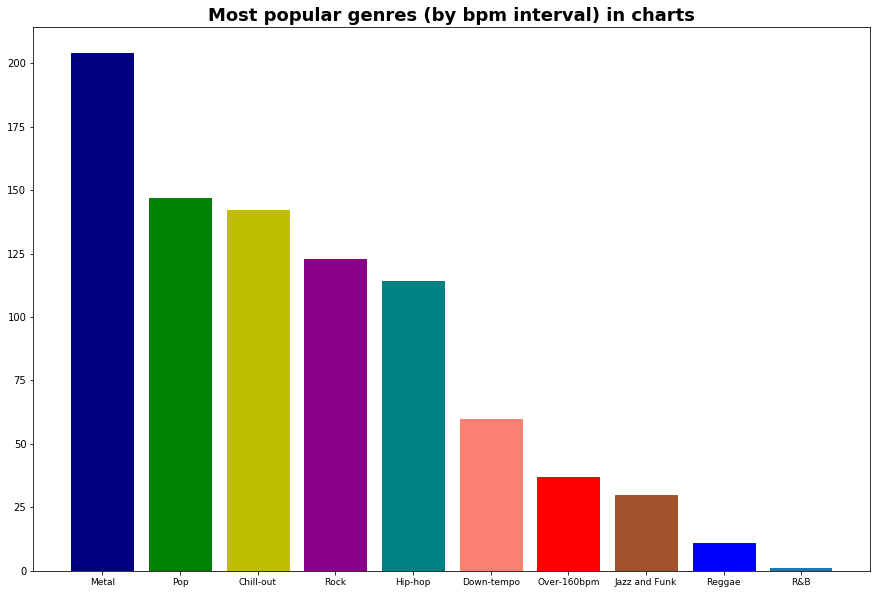

In [29]:
a = plt.bar(range(len(genre_count)), list(genre_count.values()), align='center')
plt.xticks(range(len(genre_count)), list(genre_count.keys()))
a[0].set_color('navy')
a[1].set_color('g')
a[2].set_color('y')
a[3].set_color('darkmagenta')
a[4].set_color('teal')
a[5].set_color('salmon')
a[6].set_color('r')
a[7].set_color('sienna')
a[8].set_color('b')

plt.title('Most popular genres (by bpm interval) in charts', fontsize=18, fontweight='bold')
plt.tick_params(axis='x', which='major', labelsize=9)
plt.gcf().set_size_inches(15, 10)

In [30]:
metal_deepdive = all_years_bpm[(all_years_bpm['bpm'] >= 150.0) & (all_years_bpm['bpm'] <= 160.0) ]
metal_deepdive['year'].value_counts()

2013    3
2015    2
2014    2
2018    2
2017    1
2016    1
Name: year, dtype: int64

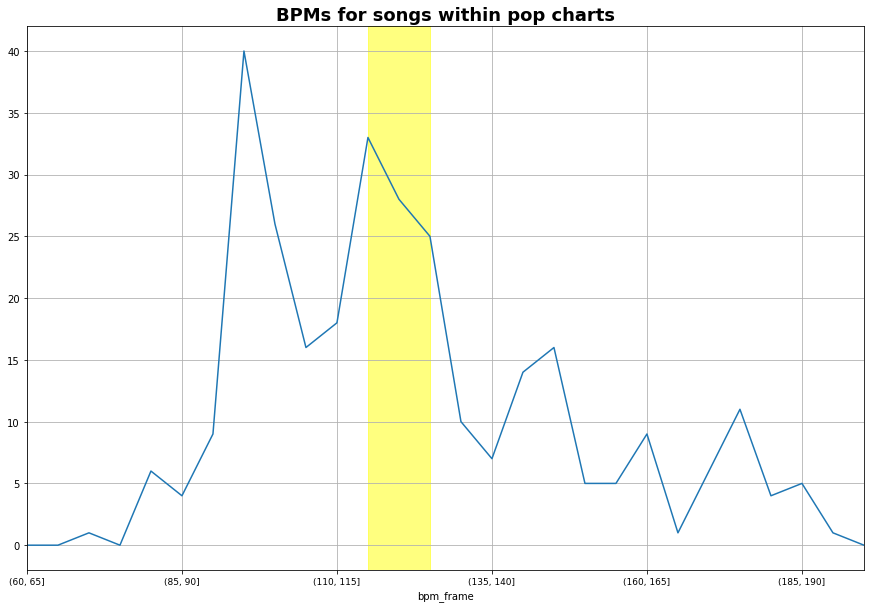

In [31]:
bpm_track_count.plot(grid = True)
plt.title('BPMs for songs within pop charts', fontsize=18, fontweight='bold')
plt.tick_params(axis='x', which='major', labelsize=9)
plt.gcf().set_size_inches(15, 10)
plt.axvspan(11,13, color='yellow', alpha=0.5)

,Genre,Min_BPM,Max_BPM,Avg_BPM
6,R&B,60,80,70.0
0,Reggae,60,90,75.0
1,Down-tempo,70,100,85.0
3,Hip-hop,85,115,100.0
2,Chill-out,90,120,105.0
5,Pop,100,130,115.0
4,Jazz and Funk,120,125,122.5
7,Rock,110,140,125.0
8,Metal,100,160,130.0


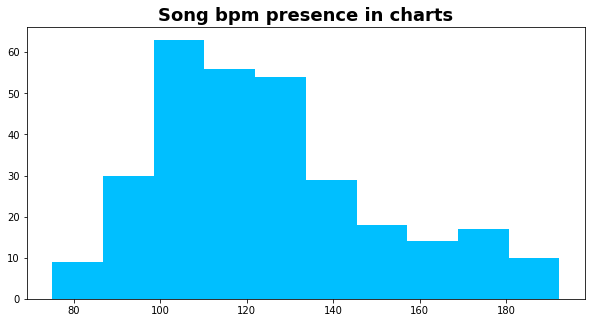

In [32]:
plt.hist('bpm', 10, facecolor='deepskyblue', data=all_years_bpm)
plt.title('Song bpm presence in charts', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(10, 5)
genre_bpm_sort

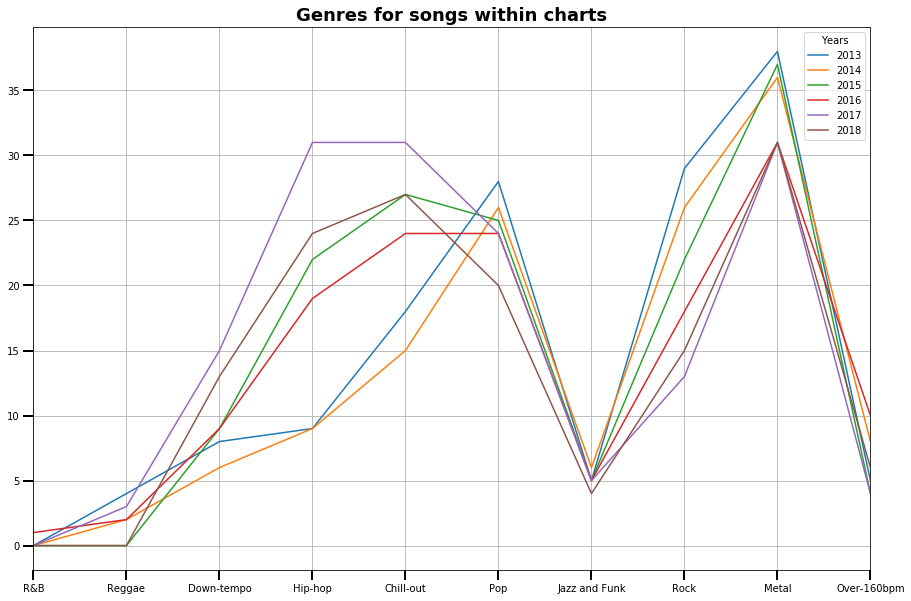

In [33]:
genre_5years.T.plot(grid = True)
plt.title('Genres for songs within charts', fontsize=18, fontweight='bold')
plt.tick_params(which='both', length=10, width=2)
plt.gcf().set_size_inches(15, 10)

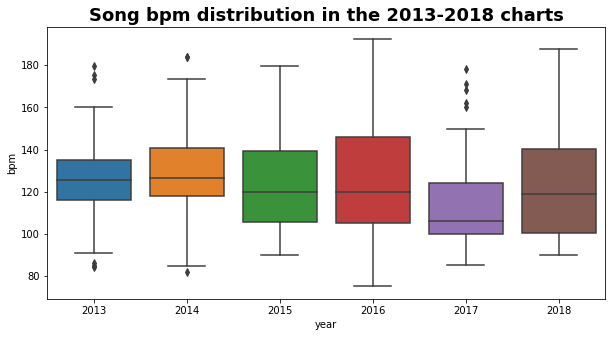

In [34]:
sb.boxplot(x='year', y='bpm', data = all_years_bpm)
plt.title('Song bpm distribution in the 2013-2018 charts', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(10, 5)

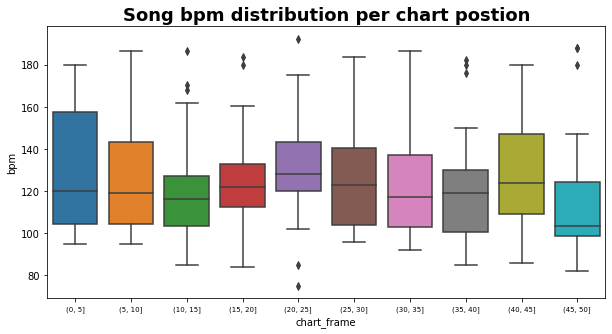

In [35]:
sb.boxplot(x='chart_frame', y='bpm', data = chart_df)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.title('Song bpm distribution per chart postion', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(10, 5)

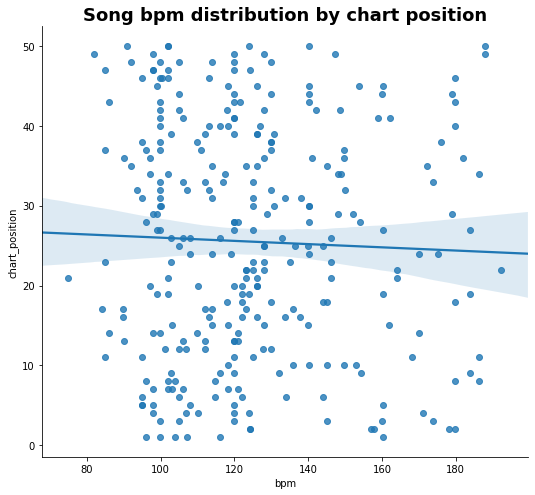

In [36]:
sb.lmplot(x="bpm", y="chart_position", data=all_years_bpm)
plt.title('Song bpm distribution by chart position', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(8, 7)

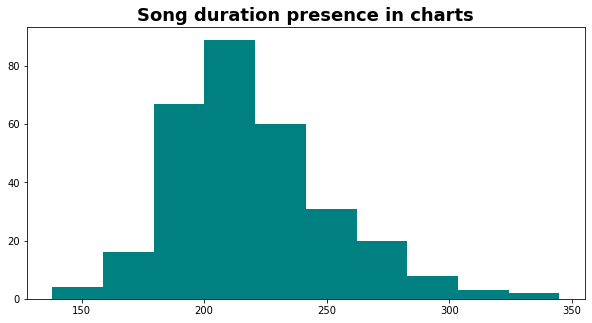

In [37]:
plt.hist('duration', 10, facecolor='teal', data=all_years_bpm)
plt.title('Song duration presence in charts', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(10, 5)

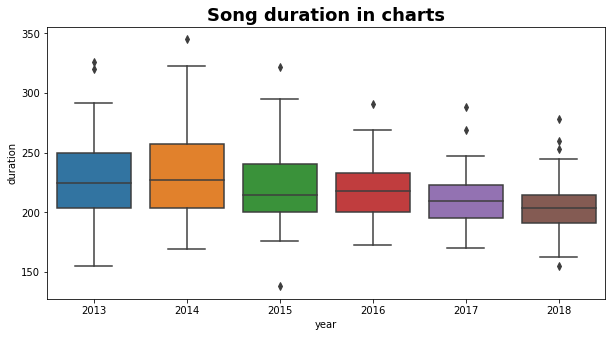

In [38]:
sb.boxplot(x='year', y='duration', data = all_years_bpm)
plt.title('Song duration in charts', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(10, 5)

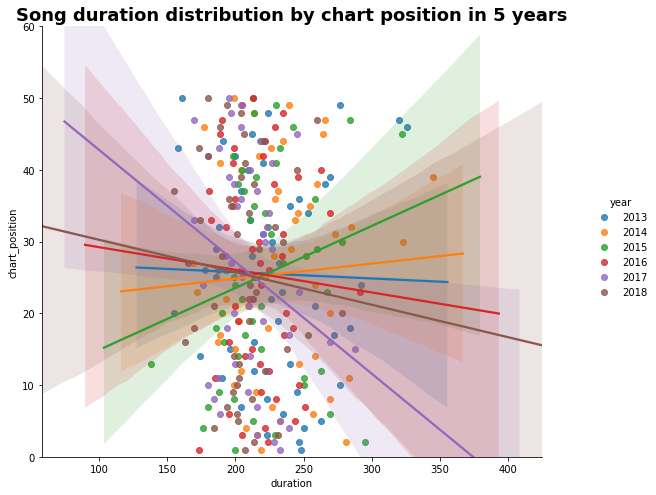

In [39]:
lm2 = sb.lmplot(x="duration", y="chart_position", hue="year", data=all_years_bpm)
axes = lm2.axes
axes[0,0].set_ylim(0,60)

plt.title('Song duration distribution by chart position in 5 years', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(10, 7)

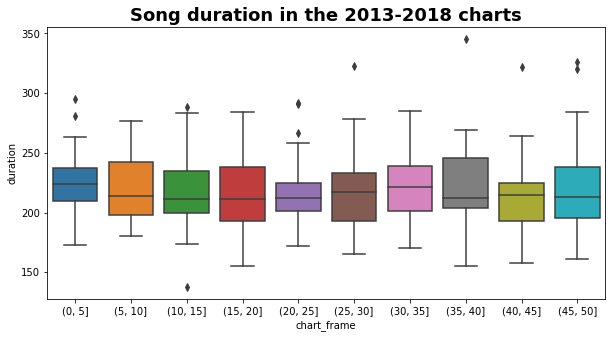

In [40]:
#little analysis relevance
sb.boxplot(x='chart_frame', y='duration', data = chart_df)
plt.title('Song duration in the 2013-2018 charts', fontsize=18, fontweight='bold')
plt.gcf().set_size_inches(10, 5)